In [1]:
import sys
import os
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
import scipy.sparse as sp
#from scipy.sparse import random
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
import scipy.optimize as sop
import seaborn
import random


# NOTE: I am ignoring the max iteration warnings for nmf
import warnings
warnings.filterwarnings("ignore")

cwd = os.getcwd()
#par = os.path.join(cwd, os.pardir)
par = os.path.dirname(cwd)
sys.path.append(par)

import sparse_nmf
import diffusion_nmf
import importlib
importlib.reload(sparse_nmf)
importlib.reload(diffusion_nmf)
from sparse_nmf import SparseNMF
from diffusion_nmf import DiffusionNMF

### Generate Data

In [2]:
def gen_data():
    # generates testing data
    test_h = sp.random(4,52, density = 0.07).A
    
    # make sure the rows aren't too correlated with each other and that there are no zero rows
    while np.linalg.norm(np.corrcoef(test_h) - np.identity(4)) > 0.2 or np.where(np.sum(test_h, axis = 1) == 0)[0].size != 0:
        test_h = sp.random(4,52, density = 0.07).A
    H = pd.DataFrame(test_h)

    x = np.linspace(1,10,300)
    y1 = stats.norm.pdf(x, 5) * 20
    y2 = []
    y3 = []
    y4 = []
    for i in x:
        y2.append((i - 5)**2)
        y3.append(2 * i)
        y4.append((i - 5)**3/10 + 10)
    y4 = np.array(y4)

    
    W = pd.DataFrame(np.array([y1, y2, y3, y4]).T)
    W /= W.max().max()

    return W,H

In [3]:
W,H = gen_data()

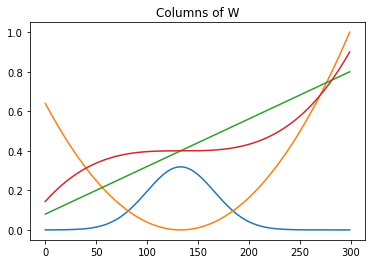

In [4]:
for col in W:
    plt.plot(W.loc[:,col])
    plt.title("Columns of W")

Text(0.5, 1.0, 'Sparse H')

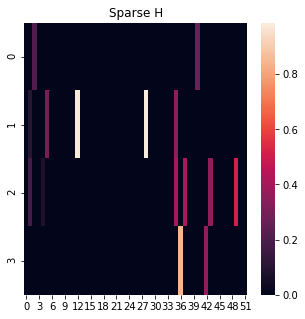

In [5]:
plt.figure(figsize = (5,5))
seaborn.heatmap(H, square = False, cbar = True)
plt.title("Sparse H")

In [6]:
# sparseness of H
def h_sparseness(h):
    h_sparse = 0
    for row in h.index:
        rh = np.array(h.loc[row,:])
        sp = math.sqrt(len(rh)) - (sum(np.abs(rh))/ math.sqrt(sum(rh ** 2)))
        sp /= (math.sqrt(len(rh)) - 1)
        h_sparse += sp
    
    h_sparse /= len(h.index)
    
    return h_sparse

In [7]:
h_sparse = h_sparseness(H)

### Preliminaries

In [8]:
def plotter(data, out_W,out_H, K_in = None, title = " "):
    # plot columns of W
    fix, ax = plt.subplots(1, 2, figsize = (10,5))
    for col in out_W:
        ax[0].plot(out_W.loc[:,col])
        ax[1].plot(W.loc[:,col])

    ax[0].set_title("W output for " + str(title))
    ax[1].set_title("Original columns of W")
    
    # plot heatmap of H
    fig, ax = plt.subplots(1, 2, figsize = (10,5))
    seaborn.heatmap(out_H, square = False, cbar = True, ax = ax[0])
    ax[0].set_title("H output for " + str(title))
    seaborn.heatmap(H, square = False, cbar = True, ax = ax[1])
    ax[1].set_title("Original H")
    
    plt.show()
    
    if K_in is None:
        print(title + "error on W: ", np.linalg.norm(W - out_W))
        print(title + "error on H: ", np.linalg.norm(H - out_H))
        print(title + "error on X: ", np.linalg.norm(data - np.dot(out_W, out_H)))
    else:
        print(title + "error on W: ", np.linalg.norm(W - out_W))
        print(title + "error on H: ", np.linalg.norm(H - out_H))
        print(title + "error on D: ", np.linalg.norm(data - np.dot(out_W, np.dot(out_H,K_in))))
    print()

In [9]:
np.linalg.norm(H)

1.9736442814166661

In [10]:
np.corrcoef(H)

array([[ 1.        , -0.05251046, -0.06422699, -0.03653971],
       [-0.05251046,  1.        ,  0.04972835, -0.04902807],
       [-0.06422699,  0.04972835,  1.        , -0.05996759],
       [-0.03653971, -0.04902807, -0.05996759,  1.        ]])

In [11]:
def reorder(w,h,x,v, err = False, err_val = 0.2):
    '''
    her = np.linalg.norm(np.corrcoef(h) - np.identity(4))
    ver = np.linalg.norm(np.corrcoef(v) - np.identity(4))
    print(her)
    print(ver)
    if ver > her + 0.2:
        pass
        #raise ValueError('Rows of V are too correlated')
    '''
    if err:
        vcor = np.corrcoef(v)
        for i in range(vcor.shape[0]):
            for j in range(vcor.shape[1]):
                if i != j and ((vcor[i][i] - vcor[i][j]) < err_val or (vcor[j][j] - vcor[i][j]) < err_val):
                    raise ValueError("Rows of V are too correlated")

    hv = np.ma.corrcoef(h, v)[0:4,4:]
    horder, vorder = sop.linear_sum_assignment(hv, maximize = True)
    
    wx = np.ma.corrcoef(w,x, rowvar = False)[4:,0:4]
    worder, xorder = sop.linear_sum_assignment(wx, maximize = True)

    #if not np.array_equal(vorder, xorder):
    #    raise ValueError("ordering is unclear")

    x = x[:,vorder]
    v = v[vorder]
    return x,v

In [12]:
def diffn_plot(w, h, lap, beta_vals, iters = 1000, algorithm = 'MultUpdate', sparseness = None, lambda_v = None, beta = None, eta = None, err = True, err_val = 0.2):
    # plot the diffusion NMF results over a range of beta values
    # parameters include original w and h, the laplacian, desired level of sparseness, total iterations for NMf
    # and options for a projection version of the algorithm and an alternating least squares version
    I = np.identity(len(lap))
    for beta in beta_vals:
            Kinv = I + beta * lap
            K = np.linalg.inv(Kinv)
                
            D = np.dot(w, np.dot(h, K))
            print("K Condition Number : " + str(np.linalg.cond(K)))

            differ = DiffusionNMF(D, K, ncomponents = 4, iterations = iters, tol = 1e-20)
            differ.solver(algorithm, sparseness, lambda_v, beta, eta)
                
            diffX,diffV = reorder(w,h,differ.X, differ.V, err = err, err_val = err_val)
            diffX = pd.DataFrame(diffX)
            diffV = pd.DataFrame(diffV)

            plotter(D, diffX, diffV, K_in = K, title = "Diffusion NMF @ beta = " + str(beta) + " ")
            
    return diffX, diffV

In [13]:
I = np.identity(np.dot(W,H).shape[1])

In [14]:
state_L = pd.read_csv(os.path.join(par, "collected_data/state_laplacian.csv"), index_col = 0).to_numpy()

### Reordering Output

K Condition Number : 30.871282980836465


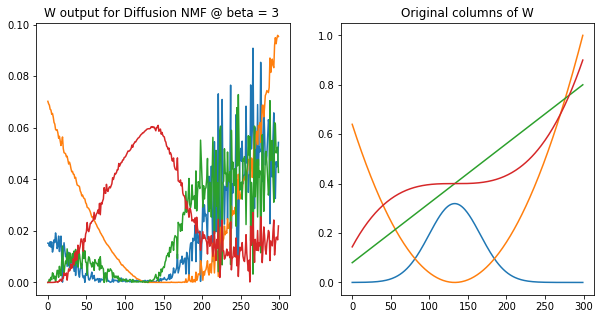

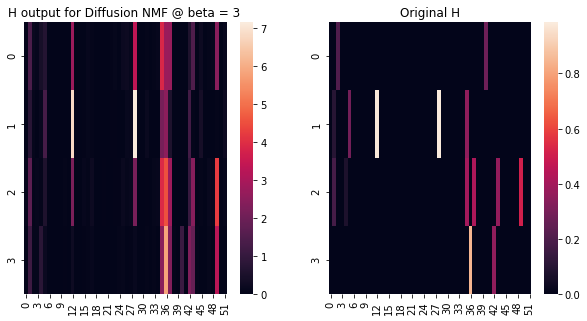

Diffusion NMF @ beta = 3 error on W:  12.888496338231858
Diffusion NMF @ beta = 3 error on H:  16.55720278158295
Diffusion NMF @ beta = 3 error on D:  0.13735437367893022



In [15]:
X,V = diffn_plot(W,H,state_L, [3], algorithm = 'MultUpdate',sparseness = None, err = False, err_val = 0.01)

K Condition Number : 10.95709432694549


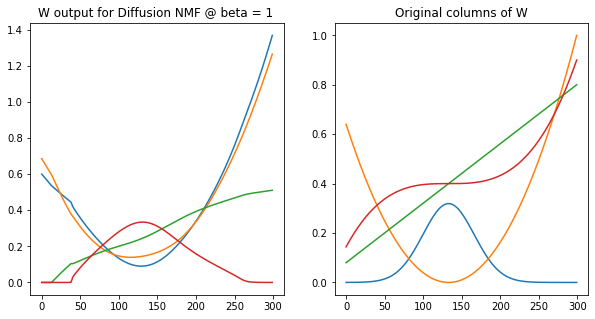

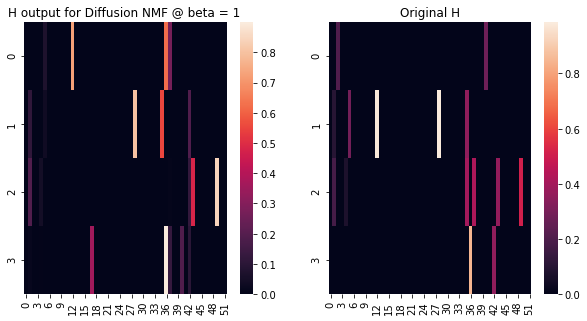

Diffusion NMF @ beta = 1 error on W:  11.997340189787453
Diffusion NMF @ beta = 1 error on H:  1.7255917607728455
Diffusion NMF @ beta = 1 error on D:  0.5617348501937988



In [16]:
X,V = diffn_plot(W,H,state_L, [1], algorithm = 'HoyerP',sparseness = h_sparse, err = True,err_val = 0.2)

K Condition Number : 30.871282980836465


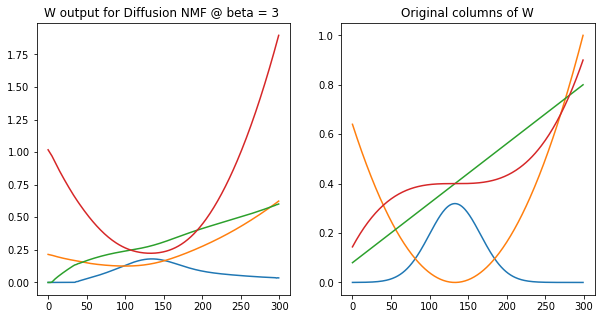

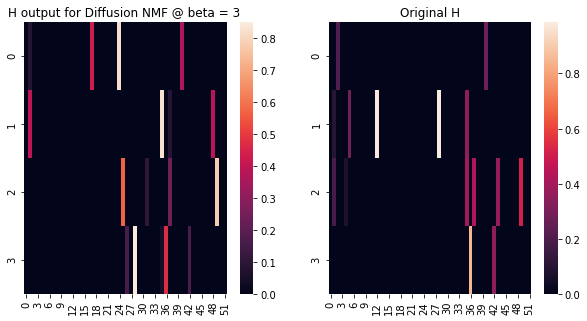

Diffusion NMF @ beta = 3 error on W:  7.791391375073789
Diffusion NMF @ beta = 3 error on H:  2.2599587415265203
Diffusion NMF @ beta = 3 error on D:  0.5774881326000745



In [17]:
X,V = diffn_plot(W,H,state_L, [3], algorithm = 'MultProj', sparseness = h_sparse, err = True, err_val = 0.2)

K Condition Number : 10.95709432694549


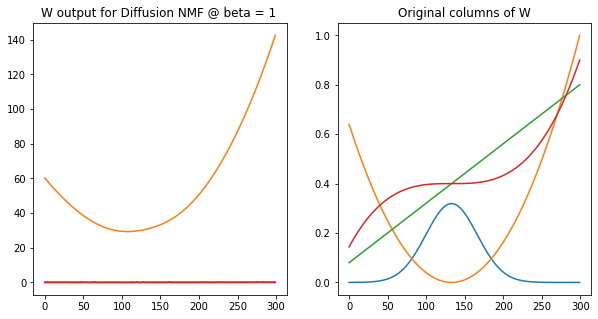

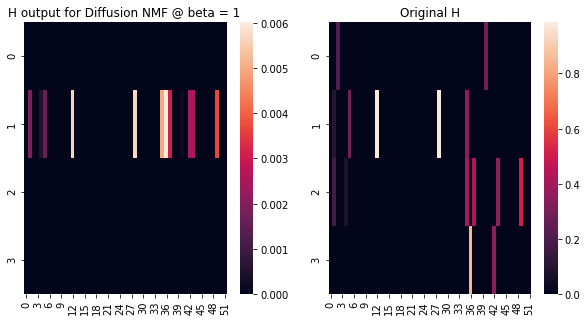

Diffusion NMF @ beta = 1 error on W:  1082.89543505665
Diffusion NMF @ beta = 1 error on H:  1.9668146803622424
Diffusion NMF @ beta = 1 error on D:  1.1866959211134949



In [19]:
X,V = diffn_plot(W,H,state_L, [1], iters = 1000, algorithm = 'HoyerS', lambda_v = 1, err = False, err_val = 0.2)

K Condition Number : 30.871282980836465


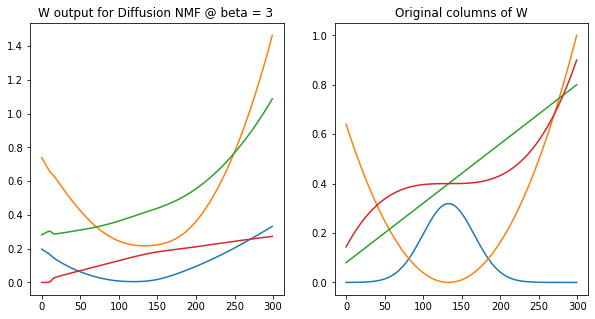

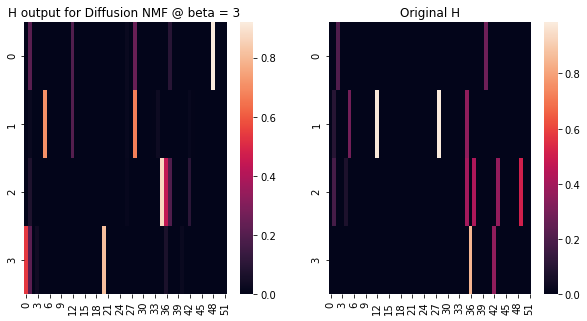

Diffusion NMF @ beta = 3 error on W:  7.514674727152877
Diffusion NMF @ beta = 3 error on H:  2.1793590201770763
Diffusion NMF @ beta = 3 error on D:  0.6407957784888507



In [20]:
X,V = diffn_plot(W,H,state_L, [3], algorithm = 'TwoPhase', sparseness = h_sparse, err = True, err_val = 0.2)

In [21]:
%%capture
def dist_tester(err_val, tries):
    multc = 0
    hoyerpc = 0
    multpc = 0
    hoyersc = 0
    twopc = 0
    for run in range(tries):
        try:
            X,V = diffn_plot(W,H,state_L, [3], algorithm = 'MultUpdate',sparseness = None, err = True, err_val = err_val)
            multc += 1
        except ValueError:
            pass
        try:
            X,V = diffn_plot(W,H,state_L, [3], algorithm = 'HoyerP',sparseness = h_sparse, err = True, err_val = err_val)
            hoyerpc += 1
        except ValueError:
            pass
        try:
            X,V = diffn_plot(W,H,state_L, [3], algorithm = 'MultProj', sparseness = h_sparse, err = True, err_val = err_val)
            multpc += 1
        except ValueError:
            pass
        try:
            X,V = diffn_plot(W,H,state_L, [1], iters = 1000, algorithm = 'HoyerS', lambda_v = 1, err = True, err_val = err_val)
            hoyersc += 1
        except ValueError:
            pass
        try:
            X,V = diffn_plot(W,H,state_L, [3], algorithm = 'TwoPhase', sparseness = h_sparse, err = True, err_val = err_val)
            twopc += 1
        except ValueError:
            pass
        
    return [multc, hoyerpc, multpc, hoyersc, twopc]

In [22]:
%%capture
resr = dist_tester(0.2,20)

Text(0.5, 1.0, '# of runs where row-wise correlation on V is distinct')

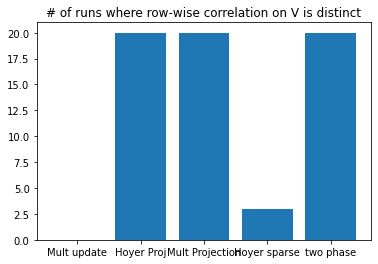

In [23]:
plt.bar(list(range(5)), resr, tick_label = ['Mult update', 'Hoyer Proj', 'Mult Projection', 'Hoyer sparse', 'two phase'])
plt.title('# of runs where row-wise correlation on V is distinct')

### Comparing algorithms

In [24]:
def correlation(x, y, axis = 1):
    # computes the correlation between matrices x and y
    summer = 0
    if axis == 0:
        for r in range(len(x.T)):
            corr = np.corrcoef(x.T[r], y.T[r])[0][1]
            if not np.isnan(corr):
                summer += corr
        cor_avg = summer / len(x.T)
        return cor_avg
    else:
        for r in range(len(x)):
            corr = np.corrcoef(x[r], y[r])[0][1]
            summer += corr
        cor_avg = summer / len(x)
        return cor_avg

In [25]:
def comparer(d,w,h,x,v,k):
    res1 = []
    res2 = []

    # Normal errors
    res1.append(np.linalg.norm(d - np.dot(x, np.dot(v, k))))
    res1.append(np.linalg.norm(w - x))
    res1.append(np.linalg.norm(h - v))

    # correlation
    d_test = np.dot(x, np.dot(v, k))
    res2.append(correlation(d, d_test, axis = 0))
    res2.append(correlation(w.to_numpy(), x, axis = 0))
    res2.append(correlation(h.to_numpy(), v, axis = 1))
    
    for ree in res1:
        if np.isnan(ree):
            print
    return res1, res2

In [26]:
def normalizer(x,v,k):
    #v_diag = []
    x = np.copy(x).astype('float')
    v = np.copy(v).astype('float')
    vk = np.dot(v, k)
    for row in range(len(vk)):
        #v_diag.append(vk[row].sum())
        fact = vk[row,:].sum()
        v[row,:] /= fact
        x[:,row] *= fact
        
    '''  
    s = np.diag(v_diag)
    try:
        s_inv = np.linalg.inv(s)
    except:
        print(s)
        raise ValueError
    '''
    
    #return np.dot(x, s), np.dot(s_inv, v)
    return x, v
    
    

In [27]:
def test_algs(d, w, h, K_b, sparseness,lambda_v = None, iters = 1000, noise = None):
    # for comparing the different algorithms
    #K_b = np.linalg.inv(I + beta * l)
    if lambda_v is None:
        lambda_v = sparseness * 10

    # algorithm 1 -- multiplicative update (no sparse constraint)
    if noise is not None:
        alg1 = DiffusionNMF(noise, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    else:
        alg1 = DiffusionNMF(d, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    alg1.solver('MultUpdate')
    rx, rv = reorder(w,h,alg1.X, alg1.V)
    rx, rv = normalizer(rx, rv, K_b)
    alg1_errs, alg1_corrs = comparer(d, w, h, rx, rv, K_b)
    

    # algorithm 2 -- modified Hoyer algorithm
    if noise is not None:
        alg2 = DiffusionNMF(noise, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    else:
        alg2 = DiffusionNMF(d, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    alg2.solver('HoyerP', sparseness = sparseness)
    rx, rv = reorder(w,h,alg2.X, alg2.V)
    rx, rv = normalizer(rx, rv, K_b)
    alg2_errs, alg2_corrs = comparer(d, w, h, rx, rv, K_b)
    

    # algorithm 3 -- projected Multiplicative update
    if noise is not None:
        alg3 = DiffusionNMF(noise, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    else:
        alg3 = DiffusionNMF(d, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    alg3.solver('MultProj', sparseness = sparseness)
    rx, rv = reorder(w,h,alg3.X, alg3.V)
    rx, rv = normalizer(rx, rv, K_b)
    alg3_errs, alg3_corrs = comparer(d, w, h, rx, rv, K_b)
    
    
    # algorithm 4 -- Hoyer sparse coding
    if noise is not None:
        alg4 = DiffusionNMF(noise, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    else:
        alg4 = DiffusionNMF(d, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    alg4.solver('HoyerS', lambda_v = lambda_v)
    rx, rv = reorder(w,h,alg4.X, alg4.V)
    rx, rv = normalizer(rx, rv, K_b)
    alg4_errs, alg4_corrs = comparer(d, w, h, rx, rv, K_b)
    

    # algorithm 5 -- two phase algorithm
    if noise is not None:
        alg5 = DiffusionNMF(noise, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    else:
        alg5 = DiffusionNMF(d, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    alg5.solver('TwoPhase', sparseness = sparseness)
    rx, rv = reorder(w,h,alg5.X, alg5.V)
    rx, rv = normalizer(rx, rv, K_b)
    alg5_errs, alg5_corrs = comparer(d, w, h, rx, rv, K_b)

    return np.array([alg1_errs, alg2_errs, alg3_errs, alg4_errs, alg5_errs]), np.array([alg1_corrs, alg2_corrs, alg3_corrs, alg4_corrs, alg5_corrs])

In [28]:
def noiser(matr, changes, std_dev = 1):
    # add noise to a matrix using gaussian random samples
    matr = np.matrix.copy(matr)
    noises = int(changes * matr.shape[0] * matr.shape[1])
    
    taken = {take:[] for take in range(matr.shape[0])}
    for n in range(noises):
        x = random.randint(0, matr.shape[0] - 1)
        while True:
            y = random.randint(0, matr.shape[1] - 1)
            if y not in taken[x]:
                break
        
        noisy = np.random.normal(scale = std_dev)
        if matr[x, y] + noisy < 0:
            matr[x, y] = 0
        else:
            matr[x, y] += noisy
            
    return matr

In [29]:
def test_with_noise(tests, K, iters = 1000):
    cols = ['Mult Update', 'Hoyer Proj', 'Mult Projection', 'Hoyer sparse', 'Two Phase']
    index = []
    for t in tests:
        index += [t] * 3
    #alg_err = [[[] for i in range(len(tests))] for i in range(5)]
    #alg_corr = [[[] for i in range(len(tests))] for i in range(5)]
    alg_err = pd.DataFrame(columns = cols, index = index)
    alg_corr = pd.DataFrame(columns = cols, index = index)
    
    
    for t in range(len(tests)):
        w,h = gen_data()
        w,h = normalizer(w,h,K)
        w = pd.DataFrame(w)
        h = pd.DataFrame(h)
        #w.to_csv(os.path.join(par, "test_data", "w_test_" + str(t)))
        #h.to_csv(os.path.join(par, "test_data", "h_test_" + str(t)))
        d = np.dot(w, np.dot(h, K))
        d_noise = noiser(d, 0.2, tests[t])
        spar = h_sparseness(h)
        
        for b in range(10):
            errz, corrz = test_algs(d,w,h,K, sparseness = spar,lambda_v = None, iters = iters, noise = d_noise)
            
            for e in range(len(errz)):
                # errors 
                #if alg_err.loc[tests[t], cols[e]].isnull().values.all():
                #    alg_err.loc[tests[t], cols[e]] = errz[e]
                #else:
                for r in range(len(errz[e])):
                    if np.isnan(alg_err.iloc[t*3 + r, e]) or errz[e][r] < alg_err.iloc[t*3 + r, e]:
                        alg_err.iloc[t*3 + r, e] = errz[e][r]
                            
                # corrs
                #if alg_corr.loc[tests[t], cols[e]].isnull().values.all():
                #    alg_corr.loc[tests[t], cols[e]] = corrz[e]
                #else:
                for r in range(len(corrz[e])):
                    if np.isnan(alg_corr.iloc[t*3 + r, e]) or corrz[e][r] > alg_corr.iloc[t*3 + r, e]:
                        alg_corr.iloc[t*3 + r, e] = corrz[e][r]
        
                
    return alg_err, alg_corr

In [39]:
K_real = np.linalg.inv(I + 7 * state_L)

In [40]:
var_tests = [0,0.5,1,1.5,2,2.5,3]

In [41]:
alg_err, alg_corr = test_with_noise(var_tests, K_real)

<AxesSubplot:title={'center':'Correlation with original H'}, xlabel='Variance level of noise added to input', ylabel='Correlation coefficient'>

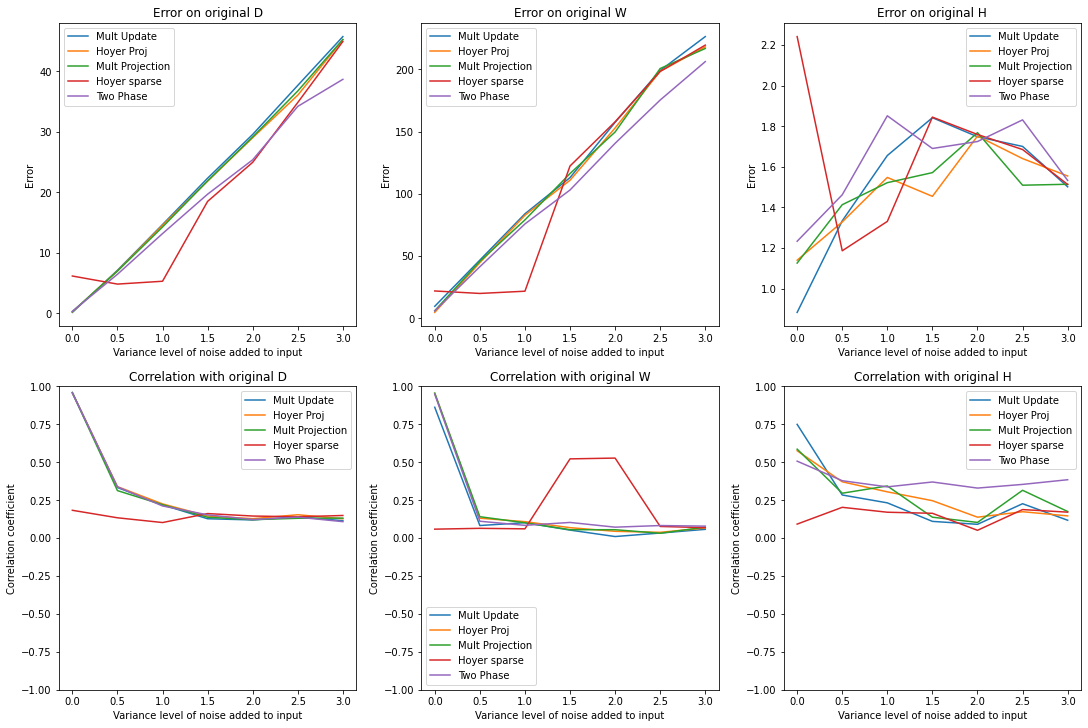

In [42]:
fig, axy = plt.subplots(2, 3, figsize = (15, 10), constrained_layout = True)
alg_err.iloc[0::3].plot(ax = axy[0][0], title = "Error on original D", xlabel = "Variance level of noise added to input", ylabel = "Error")
alg_err.iloc[1::3].plot(ax = axy[0][1], title = "Error on original W", xlabel = "Variance level of noise added to input", ylabel = "Error")
alg_err.iloc[2::3].plot(ax = axy[0][2], title = "Error on original H", xlabel = "Variance level of noise added to input", ylabel = "Error")
alg_corr.iloc[0::3].plot(ax = axy[1][0], title = "Correlation with original D", xlabel = "Variance level of noise added to input", ylabel = "Correlation coefficient", ylim = (-1,1))
alg_corr.iloc[1::3].plot(ax = axy[1][1], title = "Correlation with original W", xlabel = "Variance level of noise added to input", ylabel = "Correlation coefficient", ylim = (-1,1))
alg_corr.iloc[2::3].plot(ax = axy[1][2], title = "Correlation with original H", xlabel = "Variance level of noise added to input", ylabel = "Correlation coefficient", ylim = (-1,1))

In [43]:
alg_err

,Mult Update,Hoyer Proj,Mult Projection,Hoyer sparse,Two Phase
0.0,0.123926,0.209066,0.244984,6.144155,0.309459
0.0,9.619316,4.712447,6.077522,21.941318,5.910741
0.0,0.882464,1.139743,1.125585,2.241567,1.233052
0.5,7.087829,6.989575,6.961759,4.808514,6.431227
0.5,46.724953,44.663673,45.772547,19.949069,41.397005
0.5,1.333646,1.328208,1.413156,1.18613,1.462015
1.0,14.658005,14.52871,14.24935,5.278208,13.161558
1.0,83.934292,82.765642,79.032825,21.745122,75.793696
1.0,1.655485,1.547484,1.521715,1.33088,1.851337
1.5,22.327818,21.833456,21.886647,18.490707,19.68252
